In [13]:
import multiprocessing as mp
import numpy as np
from tqdm import tqdm
import subprocess
import cv2
import matplotlib.pyplot as plt
import torch
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform
from skimage.feature import match
import os
import sys

In [2]:
# Some utility functions
def computeNN(desc_ii, desc_jj):
    desc_ii, desc_jj = torch.from_numpy(desc_ii).cuda(), torch.from_numpy(desc_jj).cuda()
    d1 = (desc_ii**2).sum(1)
    d2 = (desc_jj**2).sum(1)
    distmat = (d1.unsqueeze(1) + d2.unsqueeze(0) - 2*torch.matmul(desc_ii, desc_jj.transpose(0,1))).sqrt()
    distVals, nnIdx1 = torch.topk(distmat, k=2, dim=1, largest=False)
    nnIdx1 = nnIdx1[:,0]
    _, nnIdx2 = torch.topk(distmat, k=1, dim=0, largest=False)
    nnIdx2= nnIdx2.squeeze()
    mutual_nearest = (nnIdx2[nnIdx1] == torch.arange(nnIdx1.shape[0]).cuda()).cpu().numpy()
    ratio_test = (distVals[:,0] / distVals[:,1].clamp(min=1e-10)).cpu().numpy()
    idx_sort = [np.arange(nnIdx1.shape[0]), nnIdx1.cpu().numpy()]
    return idx_sort, ratio_test, mutual_nearest

def subDescMatch(desc1, desc2, n_split):
    splitted_desc1 = np.split(desc1, n_split,1)
    splitted_desc2 = np.split(desc2, n_split,1)
    hist = np.zeros(shape=(len(desc1), len(desc2)))
    for d1, d2 in zip (splitted_desc1, splitted_desc2):
        idx_sort, ratio_test, mutual_nearest = computeNN(d1, d2)
        hist[idx_sort[0][mutual_nearest], idx_sort[1][mutual_nearest]] +=1

    return hist

def multiDescMatch(desc1, desc2, n_split, min_match):
    hists = []
    for d1, d2 in zip(desc1, desc2):
        hist = subDescMatch(d1, d2, n_split)
        hists.append(hist)
    final_matches = hists[0]>min_match
    if len(hists) >1:
        for h in hists[1:]:
            final_matches = np.logical_and(final_matches, h>min_match)
    final_matches = np.argwhere(final_matches)
    return final_matches
def match2DMatch(matches):
    matches = [cv2.DMatch(_queryIdx=m, _trainIdx=n, _distance=-1) for m, n in matches ]
    return matches

def homographyAddTranslation(h, translation):
    h_t = np.eye(3)
    h_t[0, 2] = translation[1]
    h_t[1, 2] = translation[0]
    return h_t @ h

def cropImage(img,percentile=.6):
    height,width=img.shape[:2]
    h=int(percentile*height/2)
    w=int(percentile*width/2)
    return img[h:-h,w:-w]

def buildCheckerBoard(size,grid_size):
    height, width = size
    ones = np.ones((grid_size, grid_size))
    zeros = np.zeros((grid_size, grid_size))
    x1 = np.concatenate((ones, zeros), axis=1)
    x2 = np.concatenate((zeros, ones), axis=1)
    x = np.concatenate((x1, x2), axis=0)

    n_h = int(height/grid_size/2) +1
    n_w = int(width/grid_size/2) + 1
    board = np.tile(x,(n_h, n_w)).astype('bool')

    return board[:height,:width]

def stichImages(img1, img2, h, grid_size=64, inverse=False):
    dst_h, dst_w = img2.shape[:2]
    dst_shape = (dst_w * 3, dst_h * 3)
    h = homographyAddTranslation(h, (dst_h, dst_w))
    transfromed_img1 = cv2.warpPerspective(img1, h, dst_shape)
    transformed_img2 = np.pad(img2, [[dst_h, dst_h], [dst_w, dst_w]])
    mask = buildCheckerBoard(dst_shape, grid_size)
    if inverse:
        img_registeded = np.where(mask.T, transfromed_img1, transformed_img2)
    else:
        img_registeded = np.where(mask.T, transformed_img2, transfromed_img1)
    img_registeded = cropImage(img_registeded)
    plt.figure(figsize=(8, 8))
    plt.imshow(img_registeded)
    plt.show()
    return

In [28]:
def clone_repo(repo_url, local_path):
    subprocess.run(['git', 'clone', repo_url, local_path])
def check_so_files(path):
  return any(os.path.exists(os.path.join(path, filename)) for filename in os.listdir(path) if filename.endswith(".so"))


class ExtractEnhancedALIKED(object):
  def __init__(self, n_descriptors=2):
    clone_repo("https://github.com/ShowStopperTheSecond/EnhancedALIKED", "/tmp/EnhancedALIKED")
    current_directory = os.getcwd()
    if not check_so_files("/tmp/EnhancedALIKED/custom_ops"):
      os.chdir("/tmp/EnhancedALIKED/custom_ops")
      subprocess.run(["bash", "/tmp/EnhancedALIKED/custom_ops/build.sh"])
    sys.path.append("/tmp/EnhancedALIKED/")
    os.chdir("/tmp/EnhancedALIKED/")
    from nets.aliked import EnhancedALIKED
    self.feature_extractor = EnhancedALIKED(load_pretrained=True, n_limit=100000,)
    os.chdir(current_directory)
    self.n_descriptors = n_descriptors

  def run(self, img):
    pred_ref = self.feature_extractor.run(img)
    kpts_ref = pred_ref['keypoints']
    desc_ref = pred_ref['descriptors'][: self.n_descriptors]
    cv_kp = cv2.KeyPoint_convert(kpts_ref)
    return cv_kp, desc_ref[0], desc_ref[1]


In [53]:

img1 = cv2.imread("/content/garden_3.jpg")
img2 = cv2.imread("/content/garden_1.jpg")

img1 = cv2.imread("/content/test_img1.jpg")
img2 = cv2.imread("/content/test_img2.jpg")

img1 = cv2.imread("/content/1.jpg")
img2 = cv2.imread("/content/4.jpg")

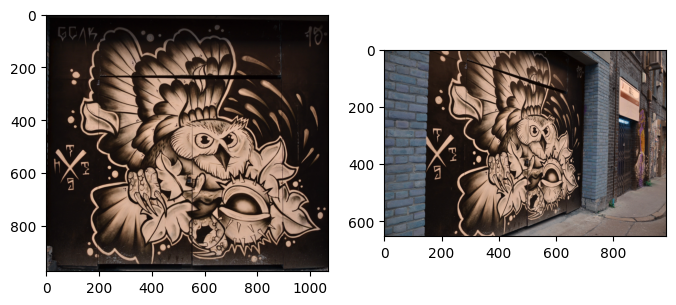

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img1)
ax[1].imshow(img2)

In [55]:
enhancedFeatureExtractor = ExtractEnhancedALIKED()

loading /tmp/EnhancedALIKED/models/aliked-n16_multiple_desc.pth


/tmp/EnhancedALIKED/nets/aliked.py:260: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pretrained_path, 'cpu')


In [56]:
kp1, desc1, ddesc1 = enhancedFeatureExtractor.run(img1)
kp2, desc2, ddesc2 = enhancedFeatureExtractor.run(img2)

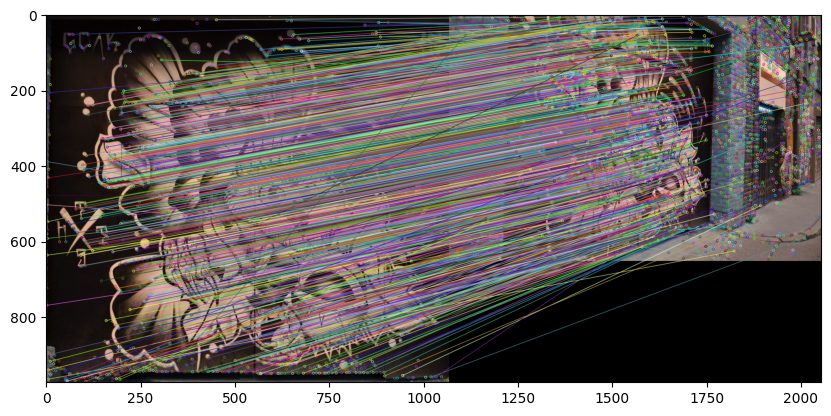

In [57]:
# Equivalent to ALIKED single descriptor
n_split = 1
min_match = 0

matches = multiDescMatch([desc1], [desc2], n_split, min_match)

cvDMatches = match2DMatch(matches)

x = cv2.drawMatches(img1, kp1, img2, kp2,cvDMatches, None)

plt.figure(figsize=(10, 5))
plt.imshow(x)

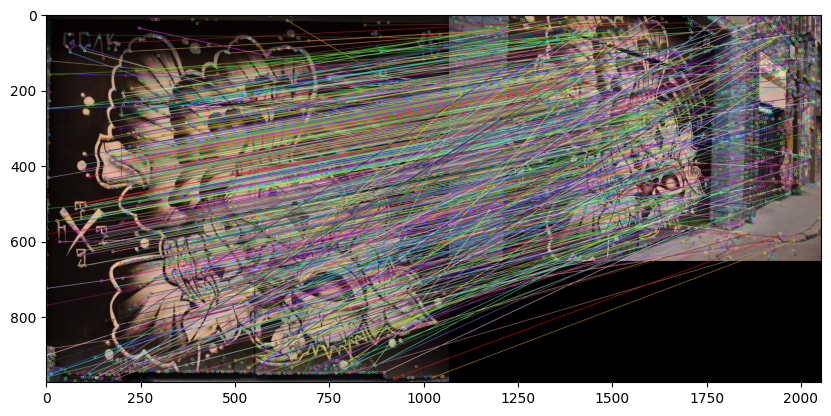

In [58]:
# Our trained second descriptor
n_split = 1
min_match = 0

ddesc1 = ddesc1.astype("float32")
ddesc2 = ddesc2.astype("float32")

matches = multiDescMatch([ddesc1], [ddesc2], n_split, min_match)

cvDMatches = match2DMatch(matches)

x = cv2.drawMatches(img1, kp1, img2, kp2,cvDMatches, None)

plt.figure(figsize=(10, 5))
plt.imshow(x)

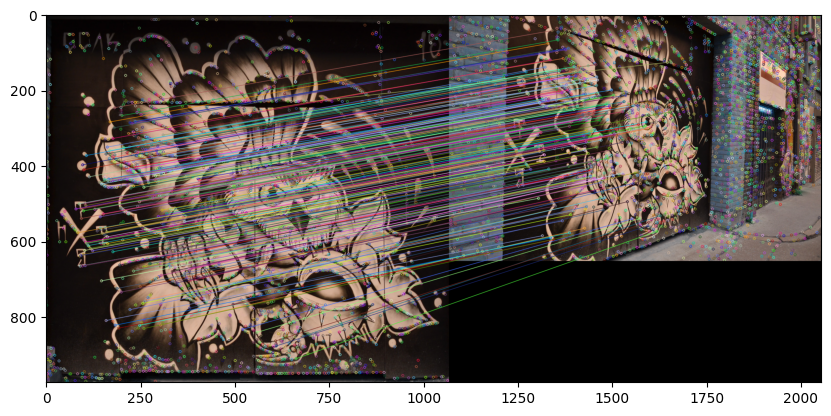

In [59]:
# Equivalent to Dual Setting with 8 sub-descriptors and min_match threshold of 3
n_split = 8
min_match = 3

ddesc1 = ddesc1.astype("float32")
ddesc2 = ddesc2.astype("float32")

matches = multiDescMatch([desc1, ddesc1], [desc2, ddesc2], n_split, min_match)

cvDMatches = match2DMatch(matches)

x = cv2.drawMatches(img1, kp1, img2, kp2,cvDMatches, None)

plt.figure(figsize=(10, 5))
plt.imshow(x)

In [60]:
model = ProjectiveTransform()

# Without any outlier removal

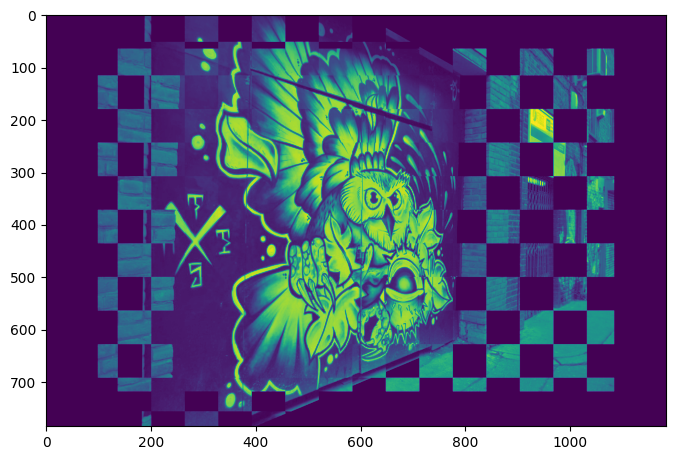

In [61]:
src_pt = np.array([a.pt for a in np.take(kp1, matches[:, 0])])
dst_pt = np.array([a.pt for a in np.take(kp2, matches[:, 1])])
model.estimate(src_pt, dst_pt)
stichImages(img1[..., 0], img2[..., 0], model.params)

# Using outlier removal

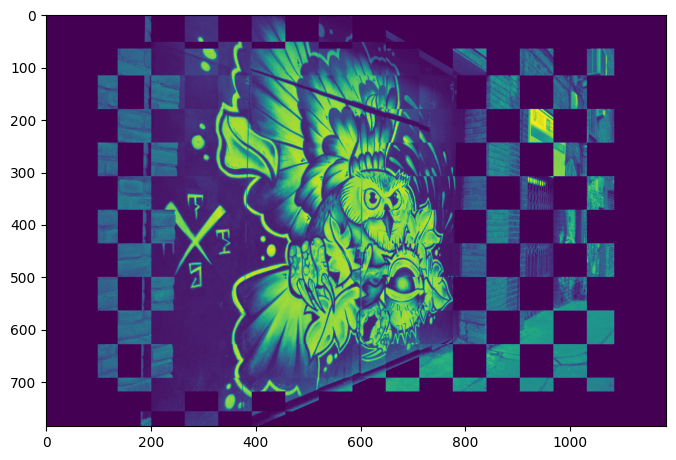

Number of all Matches:162, ROCC: 0.7641509433962265


In [62]:
src_pt = np.array([a.pt for a in np.take(kp1, matches[:, 0])])
dst_pt = np.array([a.pt for a in np.take(kp2, matches[:, 1])])
model, inliers = ransac((src_pt, dst_pt), ProjectiveTransform, 4, 1)
stichImages(img1[..., 0], img2[..., 0], model.params)
print(f"Number of all Matches:{np.sum(inliers)}, ROCC: {np.mean(inliers)}")